# Looking at particles detected at ALICE with Jupyter Notebooks

*© 2023, Oliver Matonoha, oliver.matonoha{at}hep.lu.se* <br>
*This project was created as a final project submission in the course Reproducible and Interactive Data Science taught at Lund University.*

__Abstract__: The aim of this Jupyter Notebook is to introduce high-school level students to particle physics data and their analysis. We illustrate basic concepts of High Energy Physics (HEP) and Machine Learning (ML). Specifically, an Artificial Neural Network (ANN) is built and trained. ANNs, computational models inspired by human brains, have been receiving enormous attention in the last years. Along with their popular usage in e.g. image recognition or text prediction, they are also used extensively in physics analyses. In this work, we demonstrate a very simple example of an ANN usage to solve a basic classification problem -- identifying the pion and kaon particles. We utilise Python toolkits Pandas, NumPy, and Seaborn, which greatly facilitate presenting data and its analysis in a transparent and reproducible way. Open dataset from collisions of protons detected with the ALICE experiment at the Large Hadron Collider (LHC) in CERN is used.

## Contents
- [Introduction to HEP data](#intro)
- [Python setup](#python)
- [Preparing the dataset](#dataset)
- [Measured properties of detected particles](#properties)
- [Detector coverage](#coverage)
- [Event display](#display)
- [Transverse momentum distributions](#pt)
- [Looking closer at the dataset](#closer)
- [Artificial Neural Networks](#anns)
- [Preparing the ANN](#preparingann)
- [Training the ANN](#trainingann)
- [Looking at the network's predictions](#predictions)
- [Decision boundaries](#dboundaries)
- [Conclusions](#conclusions)

## Introduction to HEP data <a name="intro"></a>

The Large Hadron Collider (LHC) is the world's largest and most powerful particle accelerator. It is located at the European Organization for Nuclear Research (CERN) in Geneva, Switzerland. The LHC was designed and built to explore the fundamental structure of the universe by colliding beams of particles at high energy levels.

The main goal of the LHC is to search for new particles and understand the basic building blocks of matter. For example, the discovery of the Higgs boson particle, which is responsible for giving other particles mass, was made using the LHC. The LHC also helps to advance our understanding of the universe by exploring the principles of symmetry and the nature of dark matter.

In addition to advancing our understanding of the universe, the LHC and its research have a range of practical applications, particularly in the fields of medicine and computing.

<img src="pictures/cern.jpg" alt="CERN LHC" width="800px" title="Large Hadron Collider at CERN. Image credit: CERN" />
<center>Large Hadron Collider at CERN. Image credit: CERN</center>

The ALICE (A Large Ion Collider Experiment) is one of the four major detectors at the LHC. It was designed to study the behavior of matter at extremely high temperatures and densities, conditions that are thought to have existed in the universe just after the Big Bang. ALICE's biggest strength is its capability to tell apart the many species of particles known as hadrons and leptons at low momentum.

Apart from protons, the ALICE experiment also uses heavy ions, such as lead, to collide with each other at high energy levels in the LHC. The collisions produce extremely high temperatures and densities, which allow the experiment to study the behavior of matter under extreme conditions. The main focus of the ALICE experiment is to study the properties of quark-gluon plasma (QGP), a state of matter that is thought to form the Universe in the first few microseconds after the Big Bang.

<img src="pictures/alice.jpg" alt="ALICE" width="400px" title="The ALICE detector. Image credit: CERN" />
<center>The ALICE detector. Image credit: CERN</center>

Data at ALICE is collected using a variety of detectors positioned around the collider. When beams of particles collide in the accelerator, they produce new particles that are detected by the detectors. The detectors measure trajectories and momenta of the particles, which is then used to reconstruct the events that took place during the collision. The data collected by the detectors is very large, on the order of petabytes, and is stored and analyzed by servers and computers across the globe. The LHC operates almost 24/7, producing a constant stream of data to be looked at by scientists to search for interesting phenomena.

In this work, we will look at an excerpt of a sample dataset from the ALICE open data. We will look at a simulated dataset. This simulation uses a physics generator to produce particles with realistic properties and a model of the detector apparatus to emulate the propagation of particles through the materials as well as their reconstruction. They represent the actual data very accurately but also contain the normally a priori unknown information -- the particle species. Thus it can be used to calculate reconstruction efficiencies of different particles or -- in our case -- train a neural network. Our dataset contains the two most abundantly produced particle species: pions ($\mathrm{\pi}$) and kaons ($\mathrm{K}$).

## Python setup <a name="python"></a>

We have to setup the environment and load all required libraries. Among others, we use:
- pandas, for easy manipulation and display of our data,
- seaborn, for visualising our data and its distributions,
- tensorflow, keras, and sklearn, to construct the neural network and measure its statistics,
- ipywidgets, to make inspecting the data interactive.

In [1]:
# Loading required packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import itertools

# NN-related libraries
import tensorflow as tf
import tensorflow.keras as keras
#import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import metrics, regularizers, optimizers
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
#from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
#from tensorflow.keras.layers import StringLookup
#from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix#, log_loss, classification_report

2023-02-03 01:28:58.074872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preparing the dataset <a name="dataset"></a>
We look at the dataset sample using shell:

In [2]:
!head -5 alicedata_piK.txt

     Row     Instance   PDGcode     Pt          Eta         Phi         NClusters   NSigmaTPC   NSigmaTOF  
        23          1         211   2.4138348   0.0267115   0.1672210         156   -0.517077   2.0222983  
        38          5         211   2.2532384   0.0701844   3.7379696         153   -0.384867   5.0170455  
        43          4        -321   2.3813841   -0.482631   5.9451336         154   -1.920060   2.9812238  
        52          2         211   2.4679009   0.7307713   2.7598619         157   0.0593901   -0.109793  


We load the data into a panda dataframe and relabel columns:

In [3]:
df = pd.read_table('alicedata_piK.txt',header=0,delim_whitespace=True,engine='python',
                  names=['event','label','particle','pt','eta','phi','nclusters','nsigmaTPC','nsigmaTOF'])
pd.set_option('display.precision', 2)
df.head(5)

,event,label,particle,pt,eta,phi,nclusters,nsigmaTPC,nsigmaTOF
0,23,1,211,2.41,0.03,0.17,156,-0.52,2.02
1,38,5,211,2.25,0.07,3.74,153,-0.38,5.02
2,43,4,-321,2.38,-0.48,5.95,154,-1.92,2.98
3,52,2,211,2.47,0.73,2.76,157,0.06,-0.11
4,70,1,-211,2.64,0.32,3.71,157,-0.59,0.36


The ```particle``` column contains the information about the particle species. Let's see what values it takes:

In [4]:
print(df.shape, df.particle.unique())

(75989, 9) [ 211 -321 -211  321]


We see four values, corresponding to positively and negatively charged pions and kaons. They use the so-called PDG particle numbering scheme. Let's encode them to strings for more illustrative data. We will also drop the 'label' column, which is not used.

In [5]:
df.loc[df.particle==211,'particle']='pi+'
df.loc[df.particle==-211,'particle']='pi-'
df.loc[df.particle==321,'particle']='K+'
df.loc[df.particle==-321,'particle']='K-'
df.drop(columns='label',inplace=True)
df.head()

,event,particle,pt,eta,phi,nclusters,nsigmaTPC,nsigmaTOF
0,23,pi+,2.41,0.03,0.17,156,-0.52,2.02
1,38,pi+,2.25,0.07,3.74,153,-0.38,5.02
2,43,K-,2.38,-0.48,5.95,154,-1.92,2.98
3,52,pi+,2.47,0.73,2.76,157,0.06,-0.11
4,70,pi-,2.64,0.32,3.71,157,-0.59,0.36


## Measured properties of detected particles <a name="properties"></a>

A collision event can look like this:
<img src="pictures/event.gif" alt="event" width="400px" />
<center>Illustration of a collision event. Image credit: CERN</center>
The geometry is defined according to the following picture (at ALICE, the definition is the same as at CMS): 
<img src="pictures/kinematics2.png" alt="kinematics" width="400px" />
<center>Geometry at the LHC experiments. The *xy*-plane is defined as the one perpendicular to the LHC. Image credit: CERN</center>

ALICE detectors tell us a lot about the measured particle properties. The Time Projection Barrel (TPC) is a large gaseous chamber which utilises the fact that charged particles leave ionisation trails in its volume, which can be detected and reconstructed into tracks. Apart from the TPC, the more precise semi-conductor detector Inner Tracking System (ITS) also assists in this.

We use the following observables to describe the kinematics of the tracks produced at the collision point:
1. __transverse momentum $p_\mathrm{T}$ (GeV/*c*)__
    - projection of the particle's momentum in th *xy*-plane. Calculated from the track's curvature in the magnetic field that the detector is subjected to. 
2. __pseudorapidity $\eta$ (-)__
    - which is defined as a function of the particle's polar angle $\theta$:
        $$\eta = - \log ( \tanh \frac{\theta}{2} ) \, \, .$$
    - The reason why $\eta$ is used in HEP is because of its close approximation to an observable called rapidity $y$, which is then related to the particle's longitudinal momentum $p_z$.
3. __azimuthal angle $\phi$__

In addition to the kinematics, ALICE detectors also tell about some other characteristics. The Time Of Flight (TOF) detector measures the time it takes for a particle to travel a given distance. Both the TPC and the TOF are used to perform Particle Identification (PID). In our dataset, we have this information:
1. __number of clusters in the TPC $\mathrm{N_{clusters}}$ (-)__ : the number of charge signals detected at the segmented read-out ends of the TPC. The more clusters, the higher quality of the track.

2. __TPC PID $\mathrm{n \sigma_{TPC}^\pi}$'s (-)__ : a measure of the track's probability to be a pion, based on the amount of energy lost to the TPC gas due to ionisation. Different particle species have different specific energy loss. It is expressed in the number of Gaussian widths from the expected value.

3. __TOF PID $\mathrm{n \sigma_{TOF}^\pi}$'s (-)__ : a measure of the track's probability to be a pion, based on the particle's velocity. Comparing the particle's velocity and momentum, the mass -- and hence species -- can be determined. It is expressed in the number of Gaussian widths from the expected value.

In the dataframe, $p_\mathrm{T}$, $\eta$, $\phi$, $\mathrm{N_{clusters}}$, $\mathrm{n \sigma_{TPC}^\pi}$, and $\mathrm{n \sigma_{TOF}^\pi}$ are labelled as `pt`, `eta`, `phi`, `nclusters`, `nsigmaTPC`, `nsigmaTOF`, respectively.


## Detector coverage <a name="coverage"></a>

We can look at our data to see which part of the area around the interaction point is well covered with our tracks.

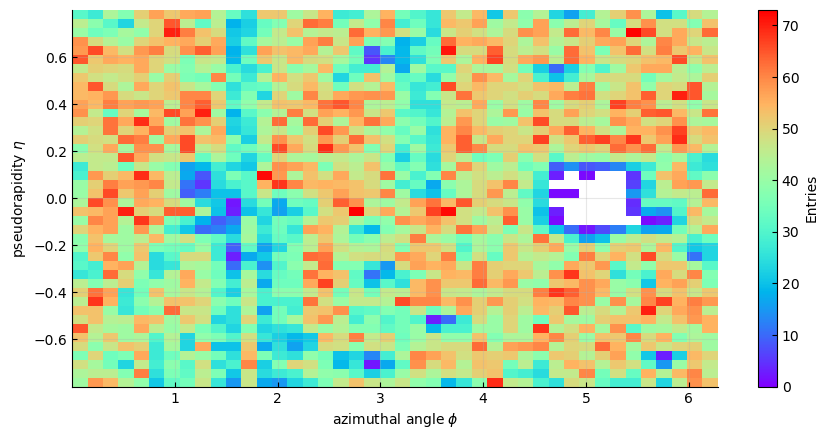

In [6]:
# Using seaborn to show a 2D distribution
g = sns.displot(x='phi',y='eta',data=df,cbar=True,cmap='rainbow',
           height=4.5,aspect=2.,cbar_kws={'label': 'Entries'})

# Adjusting styling and labelling
g.set_axis_labels("azimuthal angle $\phi$", "pseudorapidity $\eta$")
g.tick_params(axis='both',which='both',direction='in')
g.ax.grid(True,which='major',axis='both',alpha=0.3)
g.ax.margins(x=0,y=0)

Tracks in our dataset are more or less uniformly distributed in $-0.8<\eta<0.8$ and $0<\phi<2\pi$, with the exception of a hole around $\eta \approx 0$ and $\phi \approx 5$. This is likely caused by an inadequate performance of one of the ITS's subsystems during the data collection period that our simulation is tied to.

## Event display <a name="display"></a>

A display of a typical event of proton-proton collisions at ALICE can look like this:
<img src="pictures/alice_event.jpeg" alt="ALICE event" width="800px" />
<center>Event display of pp collisions at the ALICE experiment. Image credit: CERN</center>

The upper-right subplot shows the projection in the *xy*-plane. Let's look at our data and display some events with the most tracks. We will visualise them as momentum vectors. Some events reveal clear "di-jet" structures, where two highly collimated showers of particles are produced back to back. Note that in events, the sum of transverse momenta of all produced particles has to be zero, due to the law of momentum conservation. However, this does not have to be the case in the data, as it doesn't contain neutral particles, other particle species, as well as tracks with low or high momenta. 

In [7]:
# Defining the event display
def eventDisplay(eventID=10235) :
    df_ev = df[df.event==eventID].copy()
    # Adding starting positions of vectors
    df_ev['orig'] = np.zeros(len(df_ev['pt']))
    # Plotting in polar coordinates
    g = sns.FacetGrid(df_ev, hue="particle", #hue_order=["pi+","pi-","K+","K-"],
                  subplot_kws=dict(projection='polar'), height=4.5, legend_out=False,
                  despine=False)
    # Plotting each particle as a vector using quiver
    g.map(plt.quiver,"orig","orig","phi","pt",angles='xy',scale_units='xy',scale=1.)
    # Styling
    g.add_legend()
    sns.move_legend(g, "center", bbox_to_anchor=(1.1, 0.5), title='Species')
    g.set(rmin=0.,rmax=8.,yticks=[2., 5., 8.], 
          yticklabels=['2 GeV/$\it{c}$', '5 GeV/$\it{c}$', '8 GeV/$\it{c}$'], 
          xlabel="azimuthal angle $\phi$", ylabel="" )
    
# Showing a table of events with the most particles    
richEvents = df.pivot_table(index='event',values=['particle'],aggfunc='count')
richEvents = richEvents.sort_values('particle',ascending=False).head(15).T
display(richEvents)

# Using interact to display an event
interact(eventDisplay,eventID=richEvents.columns)

event,343636,10235,270312,248921,181345,65417,179277,436580,112899,13004,352750,27842,362753,956,290279
particle,12,12,11,11,10,10,10,10,9,9,9,8,8,8,8


interactive(children=(Dropdown(description='eventID', index=1, options=(343636, 10235, 270312, 248921, 181345,…

<function __main__.eventDisplay(eventID=10235)>

## Transverse momentum distributions <a name="pt"></a>

We will have a look at the distributions of transverse momentum for the $\mathrm{\pi^{\pm}}$ and $\mathrm{K^{\pm}}$ and visualise them as histograms. We also calculate and plot statistical uncertainties as errorbars. They reflect our estimate of how much can the spectra fluctuate due to randomness. The data shows that the $\mathrm{p_T}$-spectra of detected pions and kaons decrease more or less logarithmically. In order for this result to be relevant physics-wise, various corrections for detector effects would have to be applied.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


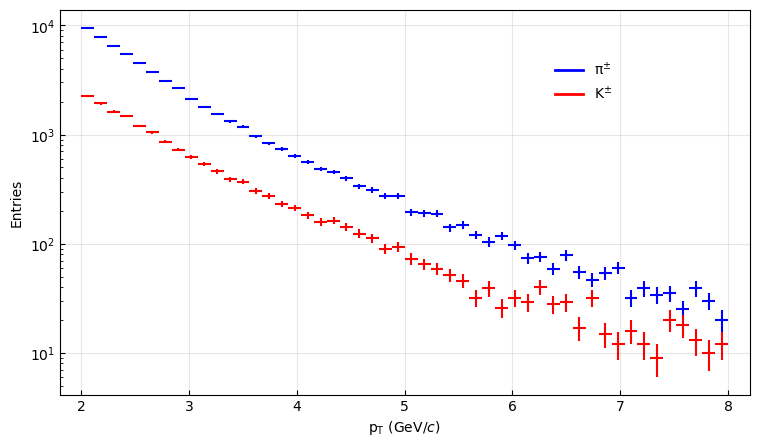

In [8]:
# Prepare histograms from the dataframe
bins = np.linspace(2.,8.0,51)
count_pi, division = np.histogram(df[(df.particle=='pi+') | (df.particle=='pi-')].loc[:,"pt"],bins=bins)
count_K, division = np.histogram(df[(df.particle=='K+') | (df.particle=='K-')].loc[:,"pt"],bins=bins)

# Calculate bin widths and bin midpoints
binw = (8.0-2.0)/(len(bins)-1)
mid = bins[:-1]+binw/2.

# Plot histograms with errorbars as barplots
fig,ax = plt.subplots(figsize=(8.9,5))
hpi = ax.bar(x=mid,height=count_pi,width=binw,yerr=np.sqrt(count_pi),
       xerr=binw/2.,color='b', ecolor='b',linewidth=0,fill=False)
hK = ax.bar(x=mid,height=count_K,width=binw,yerr=np.sqrt(count_K),
       xerr=binw/2.,color='r', ecolor='r',linewidth=0,fill=False)

# Adjust axes and styling
ax.set_xlim([1.8, 8.2])
ax.set_xlabel("$\mathrm{p_T \, \, (GeV/\it{c})}$")
ax.set_ylabel("Entries")
ax.set_yscale('log')
ax.tick_params(axis='both',which='both',direction='in')
ax.grid(True,which='major',axis='both',alpha=0.3)

# Plot custom legend
legend_elements = [Line2D([0], [0], color='b', lw=2, label='$\mathrm{\pi^{\pm}}$'),
                   Line2D([0], [0], color='r', lw=2, label='$\mathrm{K^{\pm}}$')]
ax.legend(handles=legend_elements,
    loc='upper left',
    bbox_to_anchor=(0.7,0.9),
    frameon=False)

# Saving the plot
fig.savefig('outputs/pT_spectrum_piK.eps', format='eps')
fig.savefig('outputs/pT_spectrum_piK.png', format='png', dpi=300)

## Looking closer at the dataset <a name="closer"></a>

Measurements at ALICE are typically performed as a function of $\mathrm{p_T}$ -- it is of a physical interest and also many of the detector responses and analysis techniques depend on it. Further in this notebook, we will build an ANN to distinguish pions from kaons -- also in different intervals of $\mathrm{p_T}$. Let us have a closer look at the data to get a feeling of how many particles we have in our data and what are the averages of their properties in different $\mathrm{p_T}$ bins.

In [9]:
# Showing number of particles and the averages of their properties
def showMeans(lowpt=2.,highpt=8.):
    print('The number of particles in range:\n')
    print(df[(df.pt>lowpt) & (df.pt<highpt)].pivot_table(index='particle',values=['pt'],aggfunc='count').loc[['pi+','pi-','K+','K-']])
    print('\nMeans of their properties:')
    return df[(df.pt>lowpt) & (df.pt<highpt)].pivot_table(index='particle',values=['nsigmaTOF','nsigmaTPC','nclusters','pt'],aggfunc='mean').loc[['pi+','pi-','K+','K-']]

# Making sliders which depend on each other
lowpt_widget = widgets.FloatSlider(min=2.0, max=7.5, step=0.05, value=2., continuous_update=False)
highpt_widget = widgets.FloatSlider(min=2.5, max=8.0, step=0.05, value=8., continuous_update=False)
def update_low_range(*args):
    lowpt_widget.max = 1.0 * highpt_widget.value - 0.5
highpt_widget.observe(update_low_range, 'value')

# Using interact to select the pT interval
interact(showMeans, lowpt=lowpt_widget, highpt=highpt_widget)

interactive(children=(FloatSlider(value=2.0, continuous_update=False, description='lowpt', max=7.5, min=2.0, s…

<function __main__.showMeans(lowpt=2.0, highpt=8.0)>

The properties of tracks do not largely depend on the charge. Thus, we will group negative and positive tracks together. Furthermore, we will have a look at the pair-wise correlations between the track properties.

In [10]:
# Defining intervals in pT 
ptbins = [ [2.,3.], [3.,4.], [4.,5.], [5.,6.], [6.,7.], [7.,8.] ]

# Function returning PID info for pi+- and K+- in given pT interval
def pidInfoInPt(bin):
    df_pid = df[(df.pt > ptbins[bin][0]) & (df.pt < ptbins[bin][1])] 
    df_pid = df_pid[["pt","particle","nclusters","nsigmaTPC","nsigmaTOF"]]
    for i in df_pid.index:
        if (df_pid.loc[i, "particle"] == "pi+") | (df_pid.loc[i, "particle"] == "pi-"):
            df_pid.loc[i, "particle"] = "pi"
        if (df_pid.loc[i, "particle"] == "K+") | (df_pid.loc[i, "particle"] == "K-"):
            df_pid.loc[i, "particle"] = "K"
    return df_pid

# Function plotting pair PID distributions in given pT interval
def showProperties(bin = 2):
    print("Showing properties of tracks in pT interval ", ptbins[bin][0], " < pT < ", ptbins[bin][1]," GeV/c")
    df_pid = pidInfoInPt(bin)
    ax = sns.pairplot(df_pid, hue="particle", kind="hist", corner=True, height=1.5) 
    sns.move_legend(ax, loc="center", bbox_to_anchor=(0.7, 0.8), title='Species')

# Using manual interact to choose bin and display due to larger processing time    
interact_manual(showProperties,bin=(0,4,1))

interactive(children=(IntSlider(value=2, description='bin', max=4), Button(description='Run Interact', style=B…

<function __main__.showProperties(bin=2)>

As expected, the data shows that the most important feature when distinguishing between pions and kaons is the $\mathrm{n \sigma_{TPC}^\pi}$. In the lower momentum intervals, the $\mathrm{n \sigma_{TOF}^\pi}$ also plays a role, but loses its predicting power in the higher ones.

## Artificial Neural Networks <a name="anns"></a>

Artificial Neural Networks (ANNs) are computational models inspired by the structure and function of the human brain. They consist of a large number of simple processing units, called artificial neurons, which process and transmit information.

Each artificial neuron has one or more inputs, a processing unit that performs a mathematical operation, and a single output. The inputs are typically weighted, meaning each input is multiplied by a weight factor that represents its relative importance. The weighted inputs are then combined and passed through a non-linear activation function, which produces the output of the neuron. The activation function controls the behavior of the neuron, determining whether it will fire (produce a large output) or not fire (produce a small output) for a given input.

<img src="pictures/neurons1.png" alt="Neurons" width="800px" />
<center>A biological and an artificial neuron. Image credit: Z. Meng, Y. Hu, C. Ancey</center>

Multiple Layer Perceptrons (MLPs) are a simple type of ANN which are composed of one or more layers of artificial neurons that are interconnected. For classification problems, MLPs are trained on a set of labeled examples to learn to predict the class of an unseen example. The input to the network is a set of features describing the example, and the output is a prediction of the class label. The training process involves adjusting the weights of the connections between the neurons to minimize the prediction error on the training set. Once trained, the network can be used to make predictions for new, unseen examples. In our case, they can be used to identify whether a given track is a pion or a kaon.

<img src="pictures/neurons2.png" alt="Neurons and MLP" width="800px" />
<center>Connection of two biological neurons and layers of artificial neurons into a MLP. Image credit: Z. Meng, Y. Hu, C. Ancey</center>

ANNs can have many designs and its properties are called hyper-parameters. For MLPs, they are:
- __Number of hidden layers__: determines the complexity of the model and the ability to capture complex relationships in the data. More hidden layers generally allow for more complex representations, but also increase the risk of overfitting.
- __Number of neurons per layer__: similar to number of hidden layers.
- __Activation functions__: determine the non-linearity of the model and how the neurons process the inputs. Common activation functions include sigmoid, tanh, and ReLU.
- __Learning rate__: determines the step size in the weight update rule during training. A larger learning rate can lead to faster convergence but may result in oscillations or instability. A smaller learning rate may converge more slowly but be more stable.
- __Regularization__: regularization techniques, such as L1, L2, or dropout, are used to prevent overfitting by adding constraints to the model during training.
- __Training algorithm__: determines how the model parameters are updated during training. Common algorithms include stochastic gradient descent (SGD) and its variants, such as mini-batch SGD and Adam.
- __Loss function__: measures the difference between the predicted and actual outputs and is used to guide the weight update during training. Common loss functions for classification problems include cross-entropy loss and hinge loss.
- __Batch size__: determines the number of training examples used in each weight update step during training.
- __Number of epochs__: An epoch is a complete pass over the entire training set. During each epoch, the MLP is updated using the current batch of examples.

## Preparing the ANN <a name="preparingann"></a>

First, we have to prepare our dataset. We split the data into a training set and a validation set. This is done to prevent overfitting, which occurs when the model becomes too closely adapted to the training data and performs poorly on new, unseen data.

The training set is used to fit the model by updating its parameters during training. The validation set is used to evaluate the model's performance during training, without affecting the model parameters. This provides an estimate of its performance on unseen data, and can also be used to monitor its progress during training. If it decreases or plateaus, it is a sign of overfitting and the training process should be stopped. It is also used to adjust the hyper-parameters and improve the model's architecture.

We will now prepare a MLP model to classify our data into pions and kaons, based on the input features `pt`, `nclusters`, `nsigmaTPC`, `nsigmaTOF`. The prediction targets are 0 for pions and 1 for kaons. The input features are also normalised. We look at the interval 4.0 $ < \mathrm{p_T} <$ 5.0 GeV/*c* by default. In this region, the pion and kaon distribution start to significantly overlap.

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-03 01:30:57.559647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


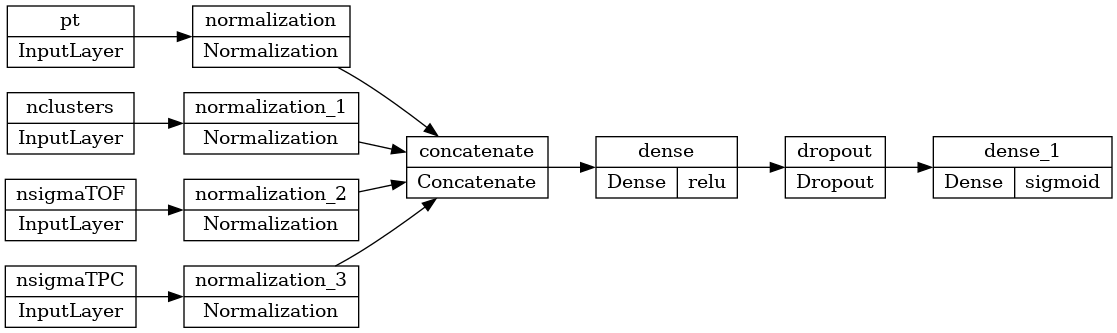

In [11]:
# Function converting pd dataframe to tf dataset
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("particle")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    return ds

# Function encoding float values in data
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()
    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    # Learn the statistics of the data
    normalizer.adapt(feature_ds)
    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

# Selecting data in one pT bin and encoding targets
df_pid = pidInfoInPt(2)
df_pid['particle'].replace(['pi', 'K'],[0, 1], inplace=True)
#display(df_pid.head())
    
# Splitting dataset into training, validation, and testing
val_dataframe = df_pid.sample(frac=0.3, random_state=1337)
train_dataframe = df_pid.drop(val_dataframe.index)
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

#for x, y in train_ds.take(1):
#    print("Input:", x)
#    print("Target:", y)

# Batching the datasets
train_ds = train_ds.batch(32, drop_remainder=True)
val_ds = val_ds.batch(32, drop_remainder=True)

# Numerical inputs
pt = keras.Input(shape=(1,), name="pt")
nclusters = keras.Input(shape=(1,), name="nclusters")
nsigmaTOF = keras.Input(shape=(1,), name="nsigmaTOF")
nsigmaTPC = keras.Input(shape=(1,), name="nsigmaTPC")
all_inputs = [pt,nclusters,nsigmaTOF,nsigmaTPC]
# Numerical features
pt_encoded = encode_numerical_feature(pt, "pt", train_ds)
nclusters_encoded = encode_numerical_feature(nclusters, "nclusters", train_ds)
nsigmaTOF_encoded = encode_numerical_feature(nsigmaTOF, "nsigmaTOF", train_ds)
nsigmaTPC_encoded = encode_numerical_feature(nsigmaTPC, "nsigmaTPC", train_ds)
all_features = layers.concatenate([pt_encoded, nclusters_encoded, nsigmaTOF_encoded, nsigmaTPC_encoded])

# Setting up MLP hyperparameters
x = layers.Dense(10, activation="relu")(all_features)
x = layers.Dropout(0.25)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

# Visualising connectivity graph of the model
keras.utils.plot_model(model, show_layer_activations=True, rankdir="LR")
#model.summary()

## Training the ANN <a name="trainingann"></a>

Having prepared the network, we can now proceed to training it. We choose 15 epochs. To measure the network's performance, we use the accuracy metric. It is calculated as the number of correct predictions divided by the total number of predictions. Given the fact that the classes in our data are not so balanced, the precision metric could also be used.

We also show the confusion matrix, which is a two-dimensional table that summarizes the model's predictions, showing the number of true positive, false positive, true negative, and false negative predictions.

Epoch 1/15
97/97 [==============================] - 1s 3ms/step - loss: 0.5692 - accuracy: 0.7474 - val_loss: 0.4781 - val_accuracy: 0.8826
Epoch 2/15
97/97 [==============================] - 0s 3ms/step - loss: 0.4601 - accuracy: 0.8708 - val_loss: 0.3786 - val_accuracy: 0.9245
Epoch 3/15
97/97 [==============================] - 0s 2ms/step - loss: 0.3697 - accuracy: 0.8985 - val_loss: 0.3071 - val_accuracy: 0.9337
Epoch 4/15
97/97 [==============================] - 0s 2ms/step - loss: 0.3167 - accuracy: 0.9130 - val_loss: 0.2547 - val_accuracy: 0.9390
Epoch 5/15
97/97 [==============================] - 0s 2ms/step - loss: 0.2769 - accuracy: 0.9253 - val_loss: 0.2183 - val_accuracy: 0.9413
Epoch 6/15
97/97 [==============================] - 0s 2ms/step - loss: 0.2474 - accuracy: 0.9185 - val_loss: 0.1945 - val_accuracy: 0.9390
Epoch 7/15
97/97 [==============================] - 0s 2ms/step - loss: 0.2281 - accuracy: 0.9236 - val_loss: 0.1779 - val_accuracy: 0.9390
Epoch 8/15
97/97 [==

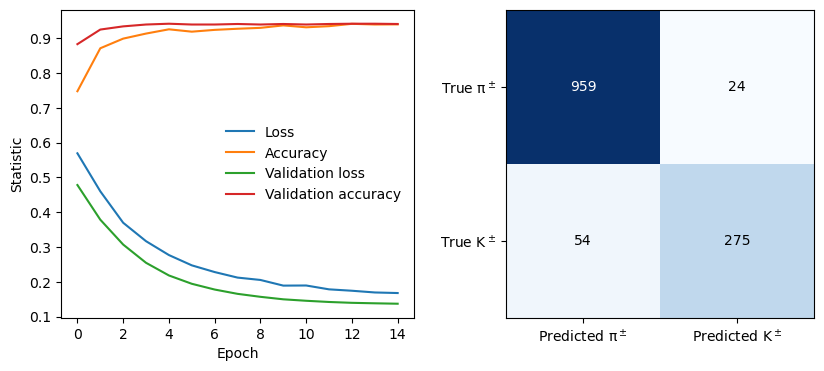

In [12]:
# Fitting the model and plotting the training progress
estimator = model.fit(train_ds, epochs=15, validation_data=val_ds)
legend_labels = { 'loss':'Loss', 'val_loss':'Validation loss', 
                 'accuracy':'Accuracy', 'val_accuracy':'Validation accuracy'}

# Plotting the training statistic evolutions
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
ax1.set_ylabel('Statistic')
ax1.set_xlabel('Epoch')
for k in estimator.history.keys():
    ax1.plot(estimator.history[k], label = legend_labels[k]) 
ax1.legend(loc='best',frameon=False)

# Calculating predictions and confusion matrix
validation_labels = np.concatenate([y for x, y in val_ds], axis=0)
prediction = model.predict(val_ds)
#validation_pred = np.argmax(prediction, axis = 1)
validation_pred = (prediction > .5) * 1
cm = tf.math.confusion_matrix(validation_labels, validation_pred)

# Plotting the confusion matrix
ax2.imshow(cm, interpolation='nearest', cmap='Blues')
classes = [0,1]
ax2.set_xticks(classes,["Predicted $\mathrm{\pi^\pm}$","Predicted $\mathrm{K^\pm}$"])
ax2.set_yticks(classes,["True $\mathrm{\pi^\pm}$","True $\mathrm{K^\pm}$"])
text_thresh = 0.5*cm.numpy().max()
for i, j in itertools.product(classes, classes):
    text = ax2.text(j, i, cm[i, j].numpy(), ha="center", va="center", 
                    color="w" if cm[i, j].numpy() > text_thresh else "k")   

# Saving the plots
fig.savefig('outputs/model_statistics.eps', format='eps')
fig.savefig('outputs/model_statistics.png', format='png', dpi=300)

## Looking at the network's predictions <a name="predictions"></a>

The trained model can now be used to classify new data. We look at the validation dataframe, calculate the prediction, and add it as a column. We can also see some of the cases where a pion or a kaon was incorrectly predicted. As expected, they are the tracks with very similar $\mathrm{n \sigma_{TPC}^{\pi}}$.

In [13]:
# Function acquiring prediction for a pd.dataframe row
def getPrediction(row):
    entry = row.to_dict()
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in entry.items()}
    result = model.predict(input_dict,verbose=0)
    return result[0][0]

# Predicting a subset of the data
df_short = val_dataframe.sample(frac=0.1, random_state=1337)
df_short['prediction'] = df_short.apply(getPrediction, axis=1)
dfid_short = df_short.copy()
dfid_short['prediction'] = (dfid_short['prediction'] > .5) * 1
dfid_short = dfid_short[['pt', 'nclusters', 'nsigmaTPC', 'nsigmaTOF', 'particle', 'prediction']]

print("Identified particles:")
display(dfid_short.head(5))

print("Incorrectly identified pions:")
mismatched_pi = dfid_short.loc[~(dfid_short['particle'] == dfid_short['prediction'])].loc[dfid_short['particle']==0]
display(mismatched_pi.head(5))

print("Incorrectly identified kaons:")
mismatched_K = dfid_short.loc[~(dfid_short['particle'] == dfid_short['prediction'])].loc[dfid_short['particle']==1]
display(mismatched_K.head(5))

# Writing predicted data to a csv file
dfid_short.to_csv('outputs/output_data_predicted.csv')

/home/matonoliv/anaconda3/envs/LUcompute/lib/python3.10/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['particle'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Identified particles:


,pt,nclusters,nsigmaTPC,nsigmaTOF,particle,prediction
61534,4.01,156,-0.65,1.62,0,0
46639,4.08,155,-1.10,-0.25,0,0
20950,4.68,159,0.94,1.68,0,0
1447,4.43,158,0.72,0.64,0,0
37868,4.03,156,-0.82,1.33,0,0


Incorrectly identified pions:


,pt,nclusters,nsigmaTPC,nsigmaTOF,particle,prediction
65665,4.05,108,-1.52,1.59,0,1
27391,4.29,159,-1.90,6.86,0,1


Incorrectly identified kaons:


,pt,nclusters,nsigmaTPC,nsigmaTOF,particle,prediction
35668,4.02,157,-1.14,2.75,1,0
70899,4.11,157,-1.67,6.11,1,0
14047,4.73,139,-1.37,0.41,1,0
69913,4.40,159,-1.63,5.38,1,0


## Decision boundaries <a name="dboundaries"></a>

To visualise the classification of our model based on the input features, let us look at the decision boundaries. The decision boundary is a hyperplane in the feature space that separates the different classes. In other words, it is the boundary between areas of input values which defines where a data point belongs to the pion or the kaon. 

Since the hyperplane is multi-dimensional, we will plot its 2D-projection in the two selected features, while fixing the others to their averages. Note that since $\mathrm{n \sigma_{TPC}^{\pi}}$ dominates the decision process, `nsigmaTPC` should always be used as one of the features to acquire feasible results. 

In [14]:
def plotDecisionBoundary(feature1='nsigmaTPC',feature2='nsigmaTOF'):
    # Create a 2D-grid from the features
    min1, max1 = df_short[feature1].min()-1, df_short[feature1].max()+1
    min2, max2 = df_short[feature2].min()-1, df_short[feature2].max()+1
    # Define the x and y resolution
    x1grid = np.linspace(min1, max1, 10)
    x2grid = np.linspace(min2, max2, 10)
    # Create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # Flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # Horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    print("Number of grid points to be predicted: ", len(grid))

    # Fixing unused features to their averages
    mean_pt = df_short['pt'].mean()
    mean_nclusters = df_short['nclusters'].mean()
    mean_nsigmaTPC = df_short['nsigmaTPC'].mean()
    mean_nsigmaTOF = df_short['nsigmaTOF'].mean()

    # Creating a dataframe from the grid
    grid_df = pd.DataFrame(columns=df_short.columns)
    for i,j in grid:
        grid_df.loc[len(grid_df.index)] = [mean_pt, 0, mean_nclusters, mean_nsigmaTPC, mean_nsigmaTOF, 0]
        grid_df.loc[grid_df.index[-1], feature1]= i
        grid_df.loc[grid_df.index[-1], feature2]= j

    # Making predictions for the grid
    grid_df['prediction'] = grid_df.apply(getPrediction, axis=1)
    yhat = grid_df['prediction'].to_numpy()
    y = df_short['particle']
    # Reshaping the predictions back into a grid
    zz = yhat.reshape(xx.shape)

    # Plotting the grid of x, y and z values as a surface
    fig,ax = plt.subplots(figsize=(6,4))
    ax.contour(xx, yy, zz, levels=[0.5], colors='black')
    c = ax.contourf(xx, yy, zz, 10, levels=np.linspace(0,1,11), cmap='RdBu_r')
    cbar = fig.colorbar(c)
    cbar.set_label('$\mathrm{K^\pm}$ probability')
    ax.scatter(df_short[df_short["particle"]==0].loc[:,feature1],df_short[df_short["particle"]==0].loc[:,feature2], 
               c="blue",s=30,edgecolors="black",label='True $\mathrm{\pi^{\pm}}$')
    ax.scatter(df_short[df_short["particle"]==1].loc[:,feature1],df_short[df_short["particle"]==1].loc[:,feature2], 
               c="orange",s=30,edgecolors="black",label='True $\mathrm{K^{\pm}}$')

    # Adjusting styling and legend
    axlabels = { 'pt':'$\mathrm{p_T \, \, (GeV/\it{c})}$','nclusters':'$\mathrm{N_{clusters}}$',
               'nsigmaTPC':'$\mathrm{n \sigma_{TPC}^{\pi}}$', 'nsigmaTOF':'$\mathrm{n \sigma_{TOF}^{\pi}}$'}
    ax.set_xlabel(axlabels[feature1])
    ax.set_ylabel(axlabels[feature2])
    ax.tick_params(axis='both',which='both',direction='in')
    ax.grid(True,which='major',axis='both',alpha=0.3)
    ax.legend(loc='best')
    
    # Saving the plot
    fig.savefig('outputs/model_dboundary_'+feature1+'_'+feature2+'.eps', format='eps')
    fig.savefig('outputs/model_dboundary_'+feature1+'_'+feature2+'.png', format='png', dpi=300)

# Using interact to select two features
features = ['pt','nclusters','nsigmaTPC','nsigmaTOF']
interact(plotDecisionBoundary,feature1=features,feature2=features)

interactive(children=(Dropdown(description='feature1', index=2, options=('pt', 'nclusters', 'nsigmaTPC', 'nsig…

<function __main__.plotDecisionBoundary(feature1='nsigmaTPC', feature2='nsigmaTOF')>

## Conclusions <a name="conclusions"></a>

In this Jupyter Notebook, we gave a concise introduction to what data from HEP experiments can look like and how ANNs can be used to identify particles. The built and trained ANN is very accurate in distinguishing pions and kaons. In reality, since we typically have to analyse billions of tracks instead of just a couple of thousands, computational speed is vital. Thus, simpler methods are usually used, e.g. simple linear cuts, decision trees, or other statistical procedures. That being said, ANNs are more fit to solve more complex problems with a large number of interdependent and non-linear features -- such as topological reconstruction of heavy-flavour particles, where data sizes are smaller and separation from background is key to extracting interesting physics results. This Notebook serves mostly for educational and demonstrational purposes. It can also serve as a starting point to explore the ANNs potential to solve more challenging and relevant cases.